In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.grid_search import GridSearchCV

import matplotlib
import matplotlib.pyplot as plt

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
from sklearn.metrics import r2_score

In [3]:
import sys
sys.path.append('../lib')

import XgbAdjustmentHelper as xgbhelper

In [24]:
munged_train_df = pd.read_csv('../data/offline/train.csv', index_col=0)
munged_test_df = pd.read_csv('../data/offline/test.csv', index_col=0)
y_train_df = pd.read_csv('../data/offline/y_train.csv', index_col=0)

X_train, X_test, y_train, y_test = train_test_split(munged_train_df.values, y_train_df.values, test_size=0.5, random_state=1729)
X_all_train = munged_train_df.values
y_all_train = y_train_df['y'].values

In [27]:
feature_names = munged_train_df.columns


Model Report
RMSE : 0.006445


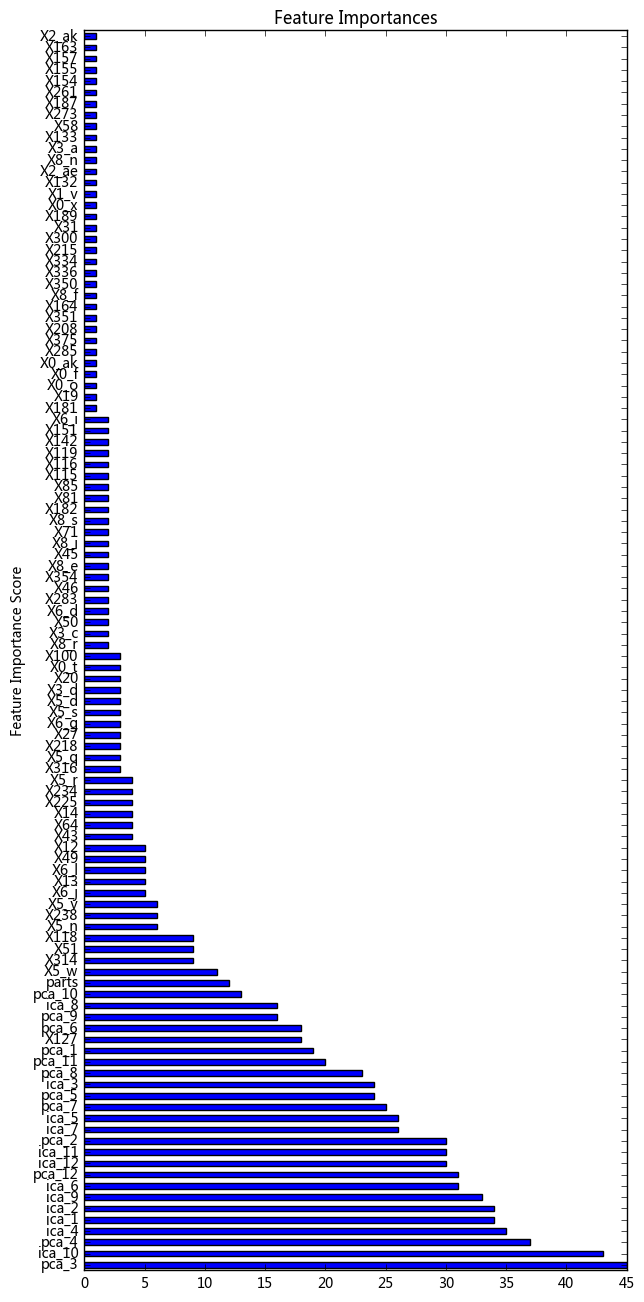

In [7]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=5000,
                             silent=False, objective='reg:linear', subsample=0.8,
                             colsample_bytree=0.8, gamma=0, min_child_weight = 1,
                             scale_pos_weight=1, seed=27)

feat_data = xgbhelper.ModelFit(xgb_model, feature_names, X_train, y_train, X_test, y_test, 13)
plt.show()

In [37]:
#粗调
xgb_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=700,\
                             silent=False, objective='reg:linear', subsample=0.75,\
                             colsample_bytree=1, gamma=0, min_child_weight = 7,\
                             scale_pos_weight=1, seed=27)

params1 = {
 'learning_rate':[0.07, 0.15, 0.1],
 'n_estimators':[70, 100, 130]
}
search = xgbhelper.ModelParamSearch(xgb_model, params1, X_all_train, y_all_train, 'r2')


grid_scores
mean: 0.55244, std: 0.07553, params: {'n_estimators': 70, 'learning_rate': 0.07}
mean: 0.54879, std: 0.06850, params: {'n_estimators': 100, 'learning_rate': 0.07}
mean: 0.54460, std: 0.06816, params: {'n_estimators': 130, 'learning_rate': 0.07}
mean: 0.53835, std: 0.06577, params: {'n_estimators': 70, 'learning_rate': 0.15}
mean: 0.52923, std: 0.06404, params: {'n_estimators': 100, 'learning_rate': 0.15}
mean: 0.52361, std: 0.06515, params: {'n_estimators': 130, 'learning_rate': 0.15}
mean: 0.54611, std: 0.06570, params: {'n_estimators': 70, 'learning_rate': 0.1}
mean: 0.54018, std: 0.06449, params: {'n_estimators': 100, 'learning_rate': 0.1}
mean: 0.53371, std: 0.06471, params: {'n_estimators': 130, 'learning_rate': 0.1}

best_params
{'n_estimators': 70, 'learning_rate': 0.07}

best_score
0.5524367275981976


In [ ]:
# grid_scores
# mean: 0.58419, std: 0.04146, params: {'n_estimators': 300, 'learning_rate': 0.1}
# mean: 0.56780, std: 0.03931, params: {'n_estimators': 500, 'learning_rate': 0.1}
# mean: 0.55673, std: 0.03853, params: {'learning_rate': 0.1, 'n_estimators': 700}
# mean: 0.59762, std: 0.04345, params: {'learning_rate': 0.05, 'n_estimators': 300}
# mean: 0.58820, std: 0.04370, params: {'n_estimators': 500, 'learning_rate': 0.05}
# mean: 0.58058, std: 0.04150, params: {'n_estimators': 700, 'learning_rate': 0.05}
# mean: -2.23612, std: 0.20937, params: {'n_estimators': 300, 'learning_rate': 0.01}
# mean: 0.56070, std: 0.07694, params: {'learning_rate': 0.01, 'n_estimators': 500}
# mean: 0.60553, std: 0.04735, params: {'n_estimators': 700, 'learning_rate': 0.01}

# best_params
# {'n_estimators': 700, 'learning_rate': 0.01}

# best_score
# 0.6055259557874768
# grid_scores
# mean: 0.59959, std: 0.04273, params: {'n_estimators': 100, 'learning_rate': 0.1}
# mean: 0.56780, std: 0.03931, params: {'n_estimators': 500, 'learning_rate': 0.1}
# mean: 0.54487, std: 0.03614, params: {'n_estimators': 1000, 'learning_rate': 0.1}
# mean: 0.50337, std: 0.02948, params: {'n_estimators': 5000, 'learning_rate': 0.1}
# mean: -157.68663, std: 10.21243, params: {'n_estimators': 100, 'learning_rate': 0.01}
# mean: 0.56070, std: 0.07694, params: {'n_estimators': 500, 'learning_rate': 0.01}
# mean: 0.60253, std: 0.04289, params: {'n_estimators': 1000, 'learning_rate': 0.01}
# mean: 0.57324, std: 0.03981, params: {'n_estimators': 5000, 'learning_rate': 0.01}
# mean: -432.48545, std: 29.95086, params: {'n_estimators': 100, 'learning_rate': 0.005}
# mean: -7.27195, std: 0.34109, params: {'n_estimators': 500, 'learning_rate': 0.005}
# mean: 0.56017, std: 0.07727, params: {'n_estimators': 1000, 'learning_rate': 0.005}
# mean: 0.59060, std: 0.04177, params: {'n_estimators': 5000, 'learning_rate': 0.005}

# best_params
# {'n_estimators': 1000, 'learning_rate': 0.01}

# best_score
# 0.6025250124501833

In [19]:
xgb_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=700,\
                             silent=False, objective='reg:linear', subsample=0.8,\
                             colsample_bytree=0.8, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27)

params2 = {
 'max_depth':[3, 4],
 'min_child_weight':[6, 7, 8]
}
search = xgbhelper.ModelParamSearch(xgb_model, params2, X_all_train, y_all_train, 'r2')


grid_scores
mean: 0.60576, std: 0.04754, params: {'max_depth': 3, 'min_child_weight': 6}
mean: 0.60603, std: 0.04764, params: {'max_depth': 3, 'min_child_weight': 7}
mean: 0.60594, std: 0.04792, params: {'max_depth': 3, 'min_child_weight': 8}
mean: 0.60507, std: 0.04768, params: {'max_depth': 4, 'min_child_weight': 6}
mean: 0.60558, std: 0.04784, params: {'max_depth': 4, 'min_child_weight': 7}
mean: 0.60496, std: 0.04802, params: {'max_depth': 4, 'min_child_weight': 8}

best_params
{'max_depth': 3, 'min_child_weight': 7}

best_score
0.6060283413417352


In [8]:
xgb_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=700,\
                             silent=False, objective='reg:linear', subsample=0.8,\
                             colsample_bytree=0.75, gamma=0, min_child_weight = 7,\
                             scale_pos_weight=1, seed=27)

params3 = {
 'subsample':[i/100.0 for i in range(60, 80, 5)],
 'colsample_bytree':[i/100.0 for i in range(85, 105, 5)]
}
search = xgbhelper.ModelParamSearch(xgb_model, params3, X_all_train, y_all_train, 'r2')


grid_scores
mean: 0.60438, std: 0.04767, params: {'subsample': 0.6, 'colsample_bytree': 0.85}
mean: 0.60476, std: 0.04732, params: {'subsample': 0.65, 'colsample_bytree': 0.85}
mean: 0.60484, std: 0.04748, params: {'subsample': 0.7, 'colsample_bytree': 0.85}
mean: 0.60521, std: 0.04762, params: {'subsample': 0.75, 'colsample_bytree': 0.85}
mean: 0.60419, std: 0.04827, params: {'subsample': 0.6, 'colsample_bytree': 0.9}
mean: 0.60452, std: 0.04789, params: {'subsample': 0.65, 'colsample_bytree': 0.9}
mean: 0.60464, std: 0.04761, params: {'subsample': 0.7, 'colsample_bytree': 0.9}
mean: 0.60517, std: 0.04780, params: {'subsample': 0.75, 'colsample_bytree': 0.9}
mean: 0.60373, std: 0.04817, params: {'subsample': 0.6, 'colsample_bytree': 0.95}
mean: 0.60453, std: 0.04813, params: {'subsample': 0.65, 'colsample_bytree': 0.95}
mean: 0.60488, std: 0.04795, params: {'subsample': 0.7, 'colsample_bytree': 0.95}
mean: 0.60542, std: 0.04812, params: {'subsample': 0.75, 'colsample_bytree': 0.95}
m

In [14]:
xgb_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=700,\
                             silent=False, objective='reg:linear', subsample=0.75,\
                             colsample_bytree=1, gamma=0, min_child_weight = 7,\
                             scale_pos_weight=1, seed=27)

params4 = {
 'reg_alpha':[0.01, 0.1, 1, 10],
}
search = xgbhelper.ModelParamSearch(xgb_model, params4, X_all_train, y_all_train, 'r2')


grid_scores
mean: 0.60589, std: 0.04800, params: {'reg_alpha': 0.01}
mean: 0.60585, std: 0.04867, params: {'reg_alpha': 0.1}
mean: 0.60178, std: 0.04944, params: {'reg_alpha': 1}
mean: 0.58620, std: 0.05555, params: {'reg_alpha': 10}

best_params
{'reg_alpha': 0.01}

best_score
0.6058871005998877


In [29]:
avg_score = 0

xgb_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=700,\
                             silent=False, objective='reg:linear', subsample=0.75,\
                             colsample_bytree=1, gamma=0, min_child_weight = 7,\
                             scale_pos_weight=1, seed=27)

for i in range(10,20):
    X_train, X_test, y_train, y_test = train_test_split(munged_train_df.values, y_train_df.values, test_size=0.19, random_state=i)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    
    score = r2_score(y_test, y_pred_xgb)
    avg_score += score
    print(score)
    
print(avg_score / 10)

0.569331086884
0.5928054513
0.460263552232
0.560512182786
0.436820106322
0.620411260168
0.54765459642
0.616690331518
0.584271931374
0.583362361882
0.557212286089


In [ ]:
0.557212286089
0.557178876366
0.555581057331
0.558875570645

In [32]:
xgb_model = xgb.XGBRegressor(max_depth=3, learning_rate=0.01, n_estimators=700,\
                             silent=False, objective='reg:linear', subsample=0.75,\
                             colsample_bytree=1, gamma=0, min_child_weight = 7,\
                             scale_pos_weight=1, seed=27)

xgb_model.fit(X_all_train, y_all_train)


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=7, missing=None, n_estimators=700, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=False, subsample=0.75)

In [36]:
y_pred = xgb_model.predict(munged_test_df.values)
output = pd.DataFrame({'id': munged_test_df.index, 'y': y_pred})
output.to_csv('xgboost-pca-ica.csv', index=False)

In [22]:
y_pred

array([ 69.72631073,  83.14871979,  70.18686676, ...,  82.90158844,
        98.74907684,  83.40969849], dtype=float32)

In [17]:
import xgboost as xgb

y_mean = np.mean(y_train_df['y'])
# prepare dict of params for xgboost to run with
xgb_params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth': 4,
    'subsample': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}

# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=500, # increase to have better results (~700)
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

[0]	train-rmse:0.118129	test-rmse:0.118133
[50]	train-rmse:0.101402	test-rmse:0.102155
[100]	train-rmse:0.0895263	test-rmse:0.09112
[150]	train-rmse:0.0812667	test-rmse:0.0837153
[200]	train-rmse:0.0755903	test-rmse:0.0788193
[250]	train-rmse:0.0717223	test-rmse:0.0756877
[300]	train-rmse:0.069071	test-rmse:0.073758
[350]	train-rmse:0.067122	test-rmse:0.0725947
[400]	train-rmse:0.0655913	test-rmse:0.0719343
[450]	train-rmse:0.0642523	test-rmse:0.071558
[499]	train-rmse:0.063031	test-rmse:0.0713823
500


In [18]:
# check f2-score (to get higher score - increase num_boost_round in previous cell)
from sklearn.metrics import r2_score

# now fixed, correct calculation
print(r2_score(dtrain.get_label(), model.predict(dtrain)))

0.698095026722


In [19]:
y_pred = model.predict(dtest)
print(r2_score(y_test, model.predict(dtest)))

0.583051317788


In [26]:
dtrain = xgb.DMatrix(munged_train_df.values, y_train_df.values)
dtest = xgb.DMatrix(munged_test_df.values)

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
dtest = xgb.DMatrix(munged_test_df.values)

In [27]:
# make predictions and save results
y_pred = model.predict(dtest)
y_pred = np.expm1(y_pred)
output = pd.DataFrame({'id': munged_test_df.index, 'y': y_pred})
output.to_csv('xgboost-depth{}-pca-ica.csv'.format(xgb_params['max_depth']), index=False)